In [164]:
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import operator
import nltk
import math
from scipy.stats import norm

from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch

In [2]:
!python -m nltk.downloader punkt

/Users/t.k/opt/anaconda3/lib/python3.8/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /Users/t.k/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
def load_data(filename):
    X = []
    Y = []
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.split("\t")
            idd = cols[0]
            label = cols[2].lstrip().rstrip()
            text = cols[3]

            X.append(text)
            Y.append(label)

    return X, Y

In [189]:
class Classifier:

    def __init__(self, feature_method, trainX, trainY, devX, devY, testX, testY):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count=2
        self.log_reg = None

        self.trainY=trainY
        self.devY=devY
        self.testY=testY
        
        self.trainX = self.process(trainX, training=True)
        self.devX = self.process(devX, training=False)
        self.testX = self.process(testX, training=False)

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            feats = self.feature_method(text)
            featurized_data.append(feats)
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):
        
        data = self.featurize(X_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]

        return X


    # Train model and evaluate on held-out data
    def train(self):
        (D,F) = self.trainX.shape
        best_dev_accuracy=0
        best_model=None
        for C in [0.1, 1, 10, 100]:
            self.log_reg = linear_model.LogisticRegression(C = C, class_weight='balanced', max_iter=1000)
            self.log_reg.fit(self.trainX, self.trainY)
            training_accuracy = self.log_reg.score(self.trainX, self.trainY)
            development_accuracy = self.log_reg.score(self.devX, self.devY)
            if development_accuracy > best_dev_accuracy:
                best_dev_accuracy=development_accuracy
                best_model=self.log_reg

            print("C: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (C, training_accuracy, development_accuracy))
            
        self.log_reg=best_model
        self.plot_confusion_matrix()
        

    def test(self):
        return self.log_reg.score(self.testX, self.testY)
        

    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

    # Plot confusion matrix on test data
    def plot_confusion_matrix(self):
        pred = self.log_reg.predict(self.testX)
        cm = confusion_matrix(self.testY, pred, normalize="all")
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.log_reg.classes_)
        disp.plot()
            

In [104]:
def binary_bow_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        feats[word]=1
            
    return feats

In [105]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [190]:
def run(trainingFile, devFile, testFile, feature_method):
    trainX, trainY=load_data(trainingFile)
    devX, devY=load_data(devFile)
    testX, testY=load_data(testFile)
    
    simple_classifier = Classifier(feature_method, trainX, trainY, devX, devY, testX, testY)
    simple_classifier.train()
    accuracy=simple_classifier.test()
    
    lower, upper=confidence_intervals(accuracy, len(testY), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

    simple_classifier.printWeights()
    
    return simple_classifier

C: 0.1, Train accuracy: 0.960, Dev accuracy: 0.790
C: 1, Train accuracy: 1.000, Dev accuracy: 0.720
C: 10, Train accuracy: 1.000, Dev accuracy: 0.730
C: 100, Train accuracy: 1.000, Dev accuracy: 0.720
Test accuracy for best dev model: 0.750, 95% CIs: [0.665 0.835]

pos	0.454	3
pos	0.313	30
pos	0.301	4
pos	0.270	it
pos	0.266	glass
pos	0.257	cut
pos	0.251	preheat
pos	0.250	around
pos	0.249	if
pos	0.248	with

neg	-0.285	season
neg	-0.262	warm
neg	-0.261	powder
neg	-0.242	vinegar
neg	-0.221	soda
neg	-0.216	more
neg	-0.206	garlic
neg	-0.201	hour
neg	-0.191	parmesan
neg	-0.187	bell



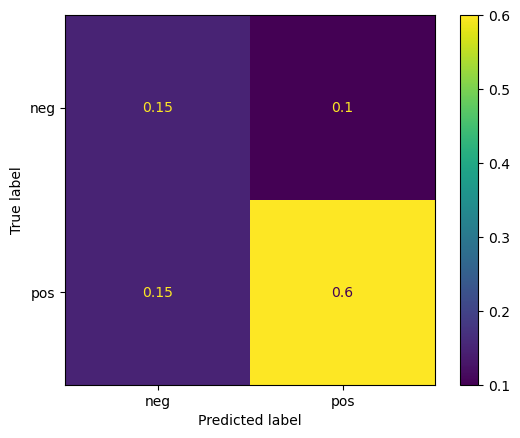

In [191]:
trainingFile = "train.txt"
devFile = "dev.txt"
testFile = "test.txt"
    
model = run(trainingFile, devFile, testFile, binary_bow_featurize)

C: 0.1, Train accuracy: 0.933, Dev accuracy: 0.760
C: 1, Train accuracy: 1.000, Dev accuracy: 0.780
C: 10, Train accuracy: 1.000, Dev accuracy: 0.770
C: 100, Train accuracy: 1.000, Dev accuracy: 0.770
Test accuracy for best dev model: 0.790, 95% CIs: [0.710 0.870]

pos	0.603	around
pos	0.591	tablespoons
pos	0.587	endive
pos	0.579	toast
pos	0.575	3/4
pos	0.556	make
pos	0.550	broth
pos	0.541	mustard
pos	0.523	still
pos	0.518	glass

neg	-0.808	season
neg	-0.708	warm
neg	-0.679	soda
neg	-0.671	powder
neg	-0.634	hour
neg	-0.596	parmesan
neg	-0.557	garlic
neg	-0.553	450°f
neg	-0.549	bell
neg	-0.540	often



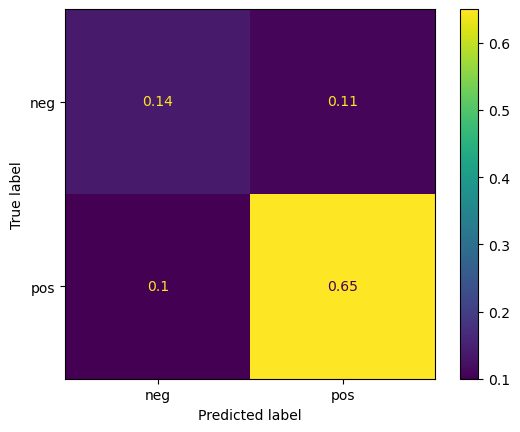

In [194]:
model_preprocessed = run(trainingFile, devFile, testFile, featurize_preprocess)

In [193]:
# preprocess
# 1. lower
# 2. remove stop words
# 3. convert number to same value
# 4. Word2Vec


def featurize_preprocess(text):
    stop_words = set(stopwords.words('english'))
    feats = {}
    
    # word_length
    feats['num_tokens'] = len(text.split())
    
    # tokenize
    words = nltk.word_tokenize(text)
            
    for word in words:
        # remove stopwords
        if word in stop_words:
            continue
        
        # convert to lowercase
        word = word.lower()

        # convert numbers to 'num_symbol'
        word = 'num_symbol' if word.isnumeric() else word
            
        feats[word] = 1
    
    return feats

In [170]:
def read_embeddings(filename, vocab_size=50000):
    """
    Utility function, loads in the `vocab_size` most common embeddings from `filename`
    
    Arguments:
    - filename:     path to file
                    automatically infers correct embedding dimension from filename
    - vocab_size:   maximum number of embeddings to load

    Returns 
    - embeddings:   torch.FloatTensor matrix of size (vocab_size x word_embedding_dim)
    - vocab:        dictionary mapping word (str) to index (int) in embedding matrix
    """

    # get the embedding size from the first embedding
    with open(filename, encoding="utf-8") as file:
        word_embedding_dim=len(file.readline().split(" ")) - 1

    vocab={}

    embeddings=np.zeros((vocab_size, word_embedding_dim))
    with open(filename, encoding="utf-8") as file:
        for idx, line in enumerate(file):
            if idx + 2 >= vocab_size:
                break
            cols=line.rstrip().split(" ")
            val=np.array(cols[1:])
            word=cols[0]
            embeddings[idx + 2]=val
            vocab[word]=idx + 2
    
    # a FloatTensor is a multidimensional matrix
    # that contains 32-bit floats in every entry
    # https://pytorch.org/docs/stable/tensors.html
    return torch.FloatTensor(embeddings), vocab

In [ ]:
labels={'pos': 1, 'neg': 0}
embs, glove_vocab=read_embeddings("glove.6B.50d.50K.txt")

In [187]:
def read_avg_embeddings(text, vocab, embs):
    """
    Utility function, loads in texts `filename` and looks up the static embeddings
    
    Arguments:
    - filename:     path to file
    - vocab:        vocab file of e.g. GloVe

    Returns 
    - embeddings:   torch.FloatTensor matrix of size (vocab_size x word_embedding_dim)
    - vocab:        dictionary mapping word (str) to index (int) in embedding matrix
    """
    
    avg_emb = np.zeros(50)
    words = nltk.word_tokenize(text)
    avg_counter = 0.
    for word in words:
        word = word.lower()
        if word in vocab:
            avg_emb += embs[vocab[word]].numpy()
            avg_counter += 1.
    avg_emb /= avg_counter
    
    feats = {f'emb_{i}' : emb for i, emb in enumerate(avg_emb)}
    return feats

C: 0.1, Train accuracy: 0.633, Dev accuracy: 0.620
C: 1, Train accuracy: 0.703, Dev accuracy: 0.700
C: 10, Train accuracy: 0.740, Dev accuracy: 0.770
C: 100, Train accuracy: 0.763, Dev accuracy: 0.750
Test accuracy for best dev model: 0.700, 95% CIs: [0.610 0.790]

pos	4.574	emb_42
pos	4.167	emb_2
pos	2.783	emb_24
pos	2.751	emb_6
pos	2.499	emb_28
pos	2.441	emb_19
pos	2.388	emb_18
pos	2.349	emb_3
pos	2.025	emb_48
pos	1.930	emb_33

neg	-3.795	emb_34
neg	-2.730	emb_22
neg	-2.652	emb_38
neg	-2.384	emb_41
neg	-2.374	emb_44
neg	-2.145	emb_49
neg	-2.045	emb_20
neg	-2.037	emb_12
neg	-1.860	emb_37
neg	-1.858	emb_43



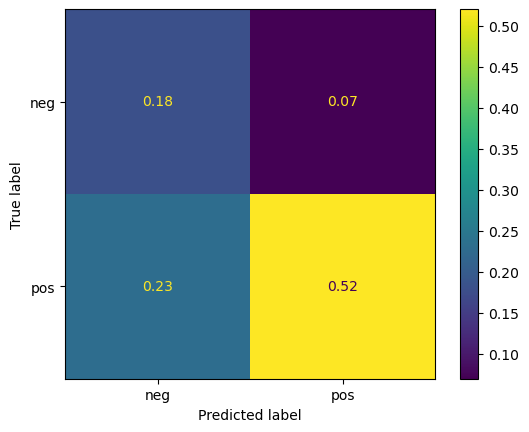

In [195]:
model_word_embedding = run(trainingFile, devFile, testFile, lambda x: read_avg_embeddings(x, glove_vocab, embs))

array([-0.00701397,  0.54196333, -0.19225432, -0.52465666,  0.77827666,
       -0.04985666, -0.31802333,  0.17465921, -0.52433   ,  0.47641918,
       -0.33454332,  0.93488999, -0.61863667, -0.16418599,  1.10000666,
        0.33991333,  0.29203001,  0.35769333,  0.07931166, -0.724163  ,
       -0.42256665,  0.87212   ,  0.70861665,  0.45412335,  1.2277    ,
       -2.06130004, -1.31806668,  0.23561666,  1.21050004, -1.26068   ,
        3.33396665,  0.74604668, -0.60947001,  0.23688667, -0.31138666,
       -0.179042  ,  0.17087666,  0.119286  ,  0.35114667, -0.56632333,
        0.09226224, -0.03197267, -0.20611999,  0.41710333,  0.168862  ,
        0.18619333,  0.08125467, -0.80106331, -0.20057967,  0.78087   ])

In [174]:
glove_vocab["love"]

837

In [181]:
for i, num in enumerate(['I', 'have']):
    print(i, num)

0 I
1 have
